In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ModuleNotFoundError: No module named 'matplotlib'

In [17]:
# Paths
dataset_dir = 'D:\Plantation/Advance/dataset'
train_dir = 'D:\Plantation/Advance/SPLIT/train'
val_dir = 'D:\Plantation/Advance/SPLIT/validation'
test_dir = 'D:\Plantation/Advance/SPLIT/test'

In [18]:
# Create directories for train, validation, and test
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

## Plot the dataset.

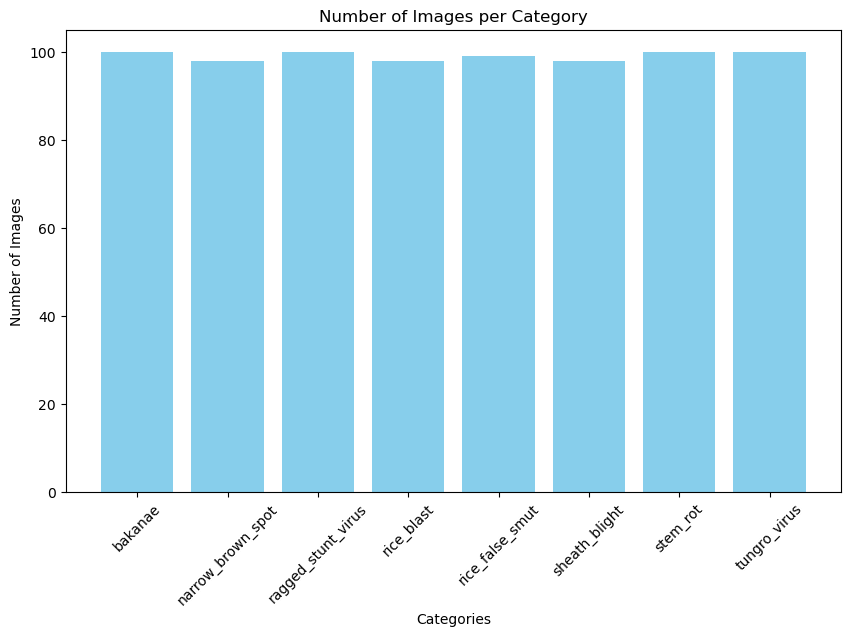

In [19]:
def plot_image_distribution(directory):
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    num_images = [len(os.listdir(os.path.join(directory, cat))) for cat in categories]
    
    plt.figure(figsize=(10, 6))
    plt.bar(categories, num_images, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Category')
    plt.xticks(rotation=45)
    plt.show()

plot_image_distribution(dataset_dir)

## Dataset Splitting.

In [20]:

categories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
for category in categories:
    cat_path = os.path.join(dataset_dir, category)
    files = os.listdir(cat_path)
    train_files, temp_files = train_test_split(files, test_size=0.4, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    
    for file_set, target_dir in [(train_files, train_dir), (val_files, val_dir), (test_files, test_dir)]:
        cat_target_dir = os.path.join(target_dir, category)
        os.makedirs(cat_target_dir, exist_ok=True)
        for file_name in file_set:
            shutil.copy(os.path.join(cat_path, file_name), os.path.join(cat_target_dir, file_name))

## Data Augmentation

In [21]:
# Data generators
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 473 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


## Model Construction

In [22]:
def build_and_compile_model(units, learning_rate):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the layers.
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Hyperparameter Tuning.
* Grid Search Method.

In [23]:
# Hyperparameter grid.
units_list = [128, 256, 512]
learning_rates = [1e-5, 1e-4, 1e-3]

best_model = None
best_val_accuracy = 0

for units in units_list:
    for learning_rate in learning_rates:
        print(f"Training with units={units} and learning_rate={learning_rate}")
        
        model = build_and_compile_model(units, learning_rate)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        model_checkpoint = ModelCheckpoint('mobilenet_transfer_advanced_learning_model.h5', save_best_only=True)
        
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[early_stopping, model_checkpoint]
        )
        
        val_accuracy = max(history.history['val_accuracy'])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model

Training with units=128 and learning_rate=1e-05
Epoch 1/10
15/15 [==============================] - 23s 1s/step - loss: 2.3745 - accuracy: 0.1205 - val_loss: 2.3036 - val_accuracy: 0.0812
Epoch 2/10
15/15 [==============================] - 20s 1s/step - loss: 2.2731 - accuracy: 0.1480 - val_loss: 2.2355 - val_accuracy: 0.1000
Epoch 3/10
15/15 [==============================] - 21s 1s/step - loss: 2.2000 - accuracy: 0.1395 - val_loss: 2.1729 - val_accuracy: 0.1312
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 2.1378 - accuracy: 0.1903 - val_loss: 2.1157 - val_accuracy: 0.1562
Epoch 5/10
15/15 [==============================] - 19s 1s/step - loss: 2.0569 - accuracy: 0.1966 - val_loss: 2.0632 - val_accuracy: 0.1750
Epoch 6/10
15/15 [==============================] - 19s 1s/step - loss: 2.0434 - accuracy: 0.2199 - val_loss: 2.0147 - val_accuracy: 0.1937
Epoch 7/10
15/15 [==============================] - 18s 1s/step - loss: 1.9786 - accuracy: 0.2389 - val_loss: 1.

In [24]:
# Evaluate the best model
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

5/5 [==============================] - 4s 813ms/step - loss: 0.1196 - accuracy: 0.9563
Test Loss: 0.1196
Test Accuracy: 0.9563


## Results Visualization.

In [25]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss over Epochs')
    
    plt.show()

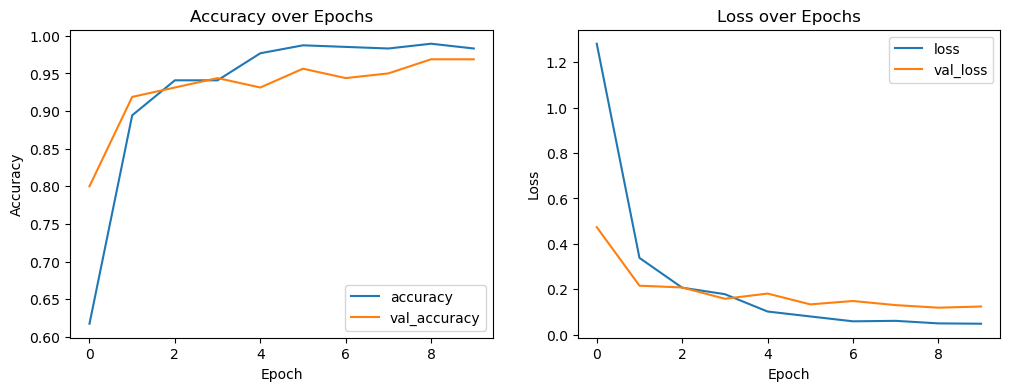

In [26]:
plot_history(history)

5/5 [==============================] - 5s 784ms/step


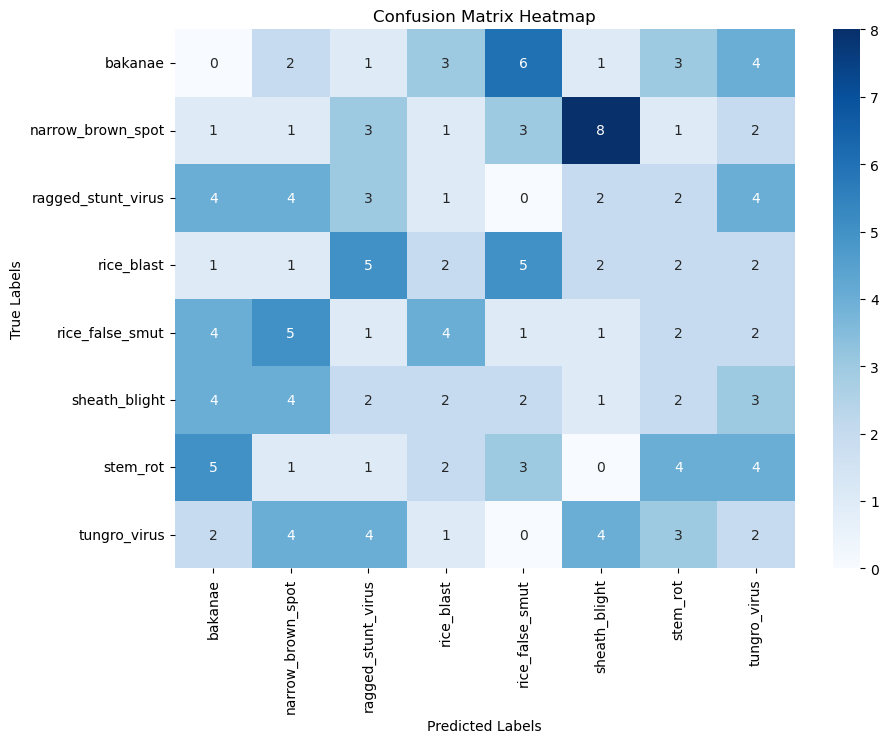

In [27]:
# Plot heatmap for the model
test_labels = test_generator.classes
test_predictions = best_model.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()